In [46]:
import numpy as np
import matplotlib.pyplot as plt
import camb
import corner

from scipy import stats
%matplotlib inline

In [33]:
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (12,7)
plt.rcParams["figure.dpi"] = 200

## Problem 1

In this problem, we try to fit some data for points on a dish to an ideal paraboloid of revolution. The general equation for a paraboloid of revolution which is azimuthally symmetric about the $z$-axis is given by
  
$$
    z - z_0 = a\Bigl((x-x_0)^2 + (y-y_0)^2\Bigr),
$$
  
where $a, x_0, y_0, z_0$ are all parameters we will be fitting for using the provided data. A linear model can be written as $\mathbf{A}\vec{m}$ where $\mathbf{A}$ is a matrix of coefficients and $\vec{m}$ is a vector of the model parameters. 

Try doing this:
  
$$
z = \zeta_0 + a(x^2 + y^2) - 2xu_0 - 2yv_0,
$$
  
where $\zeta_0 = z_0 + a(x_0^2 + y_0^2)$, $u_0 = ax_0$, and $v_0 = ay_0$.

In [3]:
dfile = "dish_zenith.txt"
data = np.genfromtxt(dfile)

In [4]:
xs, ys, zs = data.T
nparam = 4

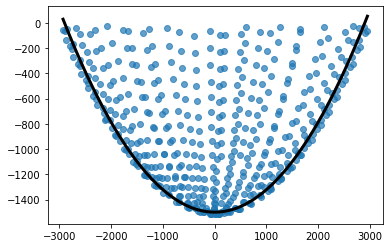

In [5]:
plt.scatter(xs,zs, alpha=0.7)
xfit = np.linspace(xs.min(), xs.max(), 500)
zfit = -1500 + 0.000178 * xfit**2
plt.plot(xfit, zfit, color='k', lw=3);

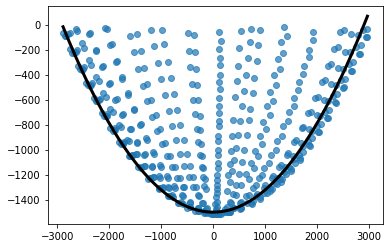

In [6]:
plt.scatter(ys,zs, alpha=0.7)
yfit = np.linspace(ys.min(), ys.max(), 500)
zfit = -1500 + 0.000178 * yfit**2
plt.plot(yfit, zfit, color='k', lw=3);

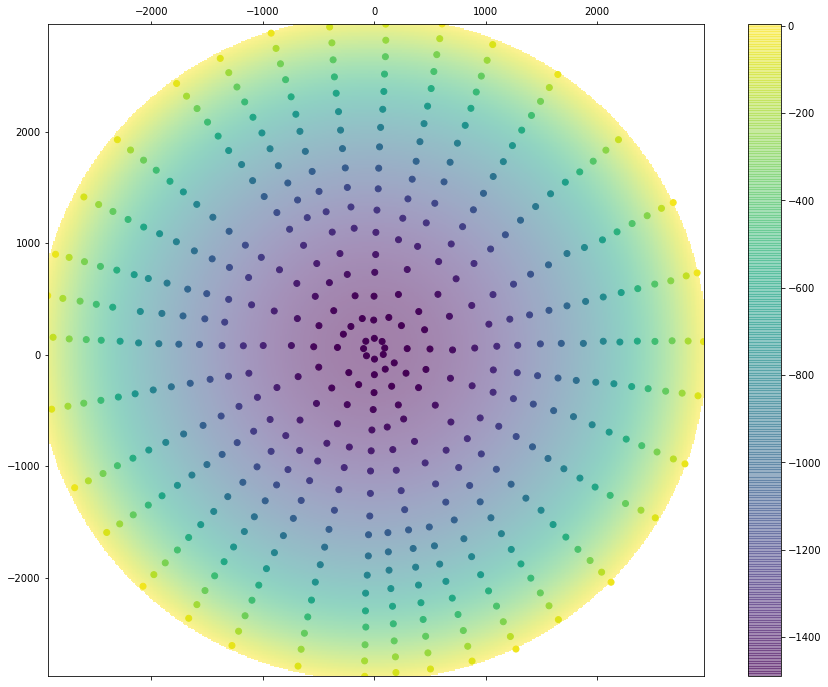

In [7]:
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
X, Y = np.meshgrid(xfit, yfit, indexing="ij")
Z = -1490 + 0.000166 * (X**2 + Y**2)
mask = np.sqrt(X**2 + Y**2) > 3000
Z = np.ma.MaskedArray(Z, mask=mask)
cax = ax.matshow(Z, extent=(xs.min(), xs.max(), ys.min(), ys.max()), alpha=0.5)
ax.scatter(xs, ys, c=zs, cmap=cax.get_cmap(), norm=cax.norm)
fig.colorbar(cax);

In [8]:
z_model = -1490 + 0.000166 * (xs**2 + ys**2)
np.std(zs - z_model)

28.472918397394114

In [9]:
# The above is about the best I can do by eye/playing around with numbers.
# So let's take that as the error on our measurements.
ninv = np.eye(xs.size) / np.std(zs - z_model)

In [10]:
Amat = np.zeros((xs.size, nparam))
Amat[:,0] = xs ** 2 + ys ** 2  # Coeffs on the a parameter
Amat[:,1] = -2 * xs  # Coeffs on the u_0 parameter
Amat[:,2] = -2 * ys  # Coeffs on the v_0 parameter
Amat[:,3] = 1  # Coeffs on the zeta_0 parameter
best_fit_params = np.linalg.inv(Amat.T @ ninv @ Amat) @ Amat.T @ ninv @ zs

In [11]:
a, u0, v0, zeta0 = best_fit_params

In [12]:
x0 = u0 / a
y0 = v0 / a
z0 = zeta0 - a * (x0**2 + y0**2)

In [13]:
x0, y0, z0

(-1.360488622197924, 58.2214760815794, -1512.8772100367873)

In [14]:
np.std(zs - (z0 + a * ( (xs - x0)**2 + (ys - y0)**2 ) ))

3.7683386487847335

In [20]:
1 / (4 * a)

1499.6599841252178

In [24]:
np.sqrt(np.diag(np.linalg.inv(Amat.T @ ninv @ Amat)))

array([9.13594925e-08, 8.85438321e-05, 8.44292385e-05, 4.41820968e-01])

## Problem 2

In [15]:
dfile = "wmap_tt_spectrum_9yr_v5.txt"
data = np.genfromtxt(dfile)
ells = data[:,0].astype(int)
powers = data[:,1]
errors = data[:,2]

In [55]:
# Rip Jon's code from the provided example.
def get_spectrum(H0, ombh2, omch2, tau, As, ns, lmax=2000):
    params = camb.CAMBparams()
    params.set_cosmology(
        H0=H0, ombh2=ombh2, omch2=omch2, tau=tau, mnu=0.06, omk=0
    )
    params.InitPower.set_params(As=As, ns=ns, r=0)
    params.set_for_lmax(lmax, lens_potential_accuracy=0)
    results = camb.get_results(params)
    powers = results.get_cmb_power_spectra(params, CMB_unit="muK")
    return powers["total"][:,0] # TT power

# Thin wrapper for conveniently getting the right sized spectrum
def calc_spectrum(ell, H0, ombh2, omch2, tau, As, ns, lmax=2000):
    if not np.isscalar(ell):
        ell = ell.astype(int)
    return get_spectrum(H0, ombh2, omch2, tau, As, ns, lmax=lmax)[ell]

In [17]:
H0 = 65 # km / s
ombh2 = 0.02
omch2 = 0.1
tau = 0.05
As = 2e-9
ns = 0.96
test_params = [H0, ombh2, omch2, tau, As, ns]
model_power = calc_spectrum(ells, *test_params)

In [18]:
resid = powers - model_power
chisq = resid @ np.diag(1 / errors ** 2) @ resid
print(f"Using the provided set of model parameters, we get a chi-squared value of {chisq}.")

Using the provided set of model parameters, we get a chi-squared value of 1588.2376356955237.


## Problem 3

In [197]:
# Hard-code varying the model parameters except the optical depth
def func_fixed_tau(ell, params):
    tau = 0.05
    H0, ombh2, omch2, As, ns = params
    return calc_spectrum(ell, H0, ombh2, omch2, tau, As, ns)

def calc_derivs(ell, params, dpars, model_func):
    """
    Calculate derivatives of CAMB model wrt params modulo optical depth.
    
    Parameters
    ----------
    ell: ndarray
        l-modes at which to evaluate model function.
    params: ndarray
        Parameters to use for evaluating provided model function.
    dpars: ndarray
        Step size to take for each parameter.
    model_func: callable
        Model function to evaluate. Should have signature
        ``model_func(ell, params)``.
        
    Returns
    -------
    derivs: ndarray
        Derivative matrix for the provided model at the provided l-modes
        and parameters. Has shape (ell.size, params.size).
        
    Notes
    -----
    This function estimates the derivative at the provided parameters
    by evaluating each partial derivative using a central difference
    method.
    """
    derivs = np.zeros([ell.size, params.size])
    for i, (param, dpar) in enumerate(zip(params, dpars)):
        new_params = params.copy()
        new_params[i] = param + dpar
        func_right = model_func(ell, new_params)
        new_params[i] = param + 2 * dpar
        func_far_right = model_func(ell, new_params)
        new_params[i] = param - dpar
        func_left = model_func(ell, new_params)
        new_params[i] = param - 2 * dpar
        func_far_left = model_func(ell, new_params)
        derivs[:,i] = (
            8 * (func_right - func_left) - (func_far_right - func_far_left)
        ) / (12 * dpar)
        #derivs[:,i] = (func_right - func_left) / (2 * dpar)
    return derivs


# Code for Newton's method taken from class. Modified for future reference.
def run_newtons_method(data, start_params, dpars, model_deriv, model_func, Nstep=10):
    """
    Run Newton's Method to find the minimum of the chisq surface.
    
    Parameters
    ----------
    data: ndarray
        Array with the data and errors, should have shape (N,3) where
        data[:,0] gives l-modes; data[:,1] gives powers; data[:,2] gives errors.
    start_params: ndarray
        Initial guess for the best-fit parameters.
    dpars: ndarray
        Step size to use for calculating the derivative of the model function.
    model_deriv: callable
        Function for calculating the derivative of the model with respect to
        the parameters. Should have signature
        ``model_deriv(ell, params, dpars, model_func)``. Output derivative
        should have shape ``(ell.size, params.size)``.
    model_func: callable
        Model function to evaluate when computing the residual and the derivatives.
        Should have signature ``model_func(ell, params)``.
    Nstep: int, optional
        Number of steps to take when running Newton's Method. Default is 10.
    
    Returns
    -------
    param_history: ndarray
        History of different parameter values taken on when running Newton's
        Method. This is the path taken through phase space. Has shape
        ``(start_params.size, Nstep + 1)``.
    chisq_history: ndarray
        Chi-squared value for each step along the path in phase space. Has
        length ``Nstep + 1`` (the extra entry is the initial chi-squard value).
    """
    ells, powers, errors = data.T
    ninv = np.diag(1 / errors ** 2)
    
    param_history = np.zeros([start_params.size, Nstep + 1])
    param_history[:, 0] = start_params
    chisq_history = np.zeros(Nstep + 1)
    for step in range(Nstep):
        model = model_func(ells, param_history[:, step])
        resid = powers - model
        
        # Calculate first derivatives of the model wrt parameters.
        derivs = model_deriv(ells, param_history[:, step], dpars, model_func)
        curvature = np.linalg.inv(derivs.T @ ninv @ derivs)
        gradient = derivs.T @ ninv @ resid
        
        # New configuration chosen by advancing along the gradient of the chisq surface.
        param_history[:, step + 1] = param_history[:, step] + curvature @ gradient
        chisq_history[step] = resid @ ninv @ resid
        
    # Record value of chi-squared at the end of the path.
    model = model_func(ells, params)
    resid = powers - model
    chisq_history[-1] = resid @ ninv @ resid
    return param_history, chisq_history

In [58]:
start_params_fixed_tau = np.array([H0, ombh2, omch2, As, ns])
dpars = 0.001 * start_params_fixed_tau
descent_path, chisq_history = run_newtons_method(
    data[:, :3], start_params_fixed_tau, dpars, calc_derivs, func_fixed_tau
)

In [198]:
best_fit_params = descent_path[:,-1]
derivs = calc_derivs(ells, best_fit_params, dpars, func_fixed_tau)
curvature = np.linalg.inv(derivs.T @ np.diag(1 / errors ** 2) @ derivs)
param_errors = np.sqrt(np.diag(curvature))
param_names = ["H_0", "ombh2", "omch2", "As", "ns"]
labels = ["$H_0$", "$h^2\Omega_b$", "$h^2\Omega_c$", r"$\tau$", "$A_s$", "$n_s$"]
for name, param, error in zip(param_names, best_fit_params, param_errors):
    print(f"Parameter {name} has best-fit value {param:.3e} with error {error:.3e}")

Parameter H_0 has best-fit value 6.933e+01 with error 2.400e+00
Parameter ombh2 has best-fit value 2.249e-02 with error 5.400e-04
Parameter omch2 has best-fit value 1.139e-01 with error 5.223e-03
Parameter As has best-fit value 2.042e-09 with error 3.901e-11
Parameter ns has best-fit value 9.698e-01 with error 1.358e-02


In [ ]:
# Check that the derivatives look OK
fractional_step_sizes = np.logspace(-1, -5, 5)
deriv_matrix = np.zeros([fractional_step_sizes.size, ells.size, params.size])
for i, step_size in enumerate(fractional_step_sizes):
    dpars = param_history[:,0] * step_size
    deriv_matrix[i] = calc_derivs_fixed_tau(ells, param_history[:,0], dpars)

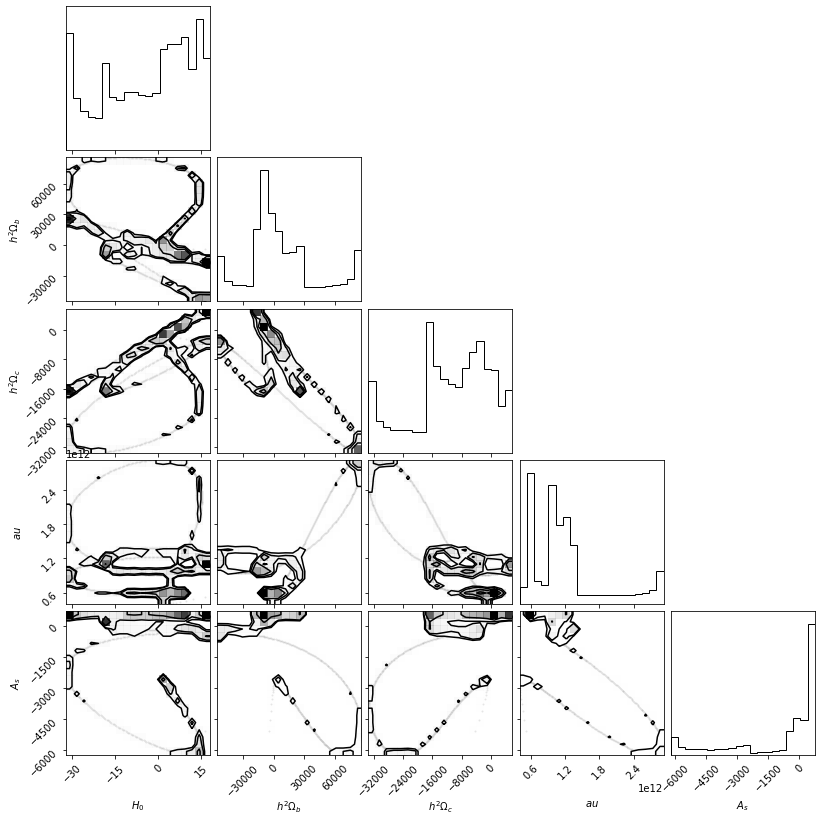

In [171]:
fig = corner.corner(deriv_matrix[-1], labels=labels)

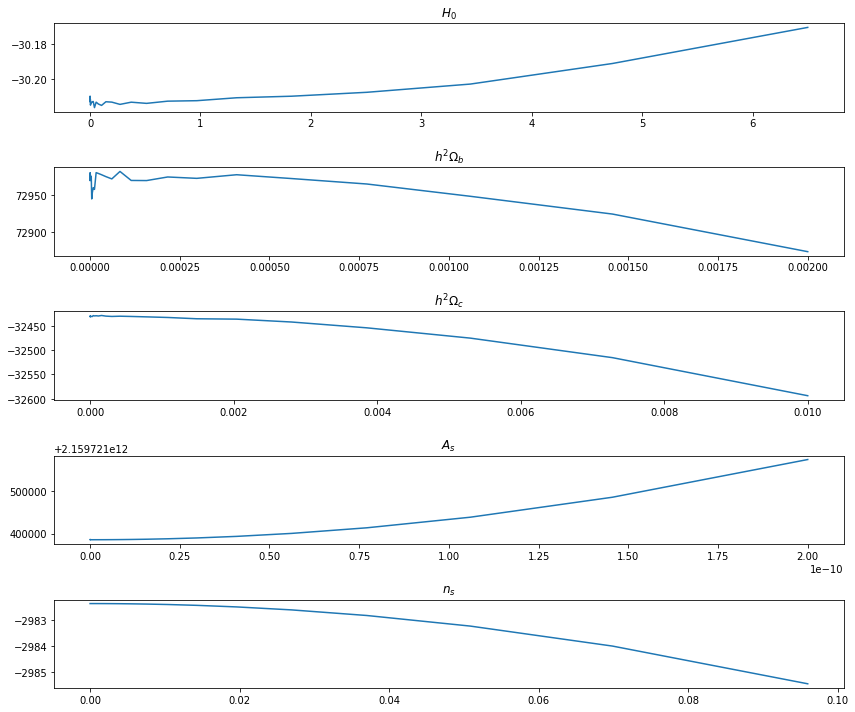

In [192]:
fig, axes = plt.subplots(5, figsize=(12,10))
for j, (ax, label) in enumerate(zip(axes.ravel(), labels[:3] + labels[4:])):
    ax.plot(fractional_step_sizes * start_params_fixed_tau[j], deriv_matrix[:, 300, j])
    ax.set_title(label)
fig.tight_layout();

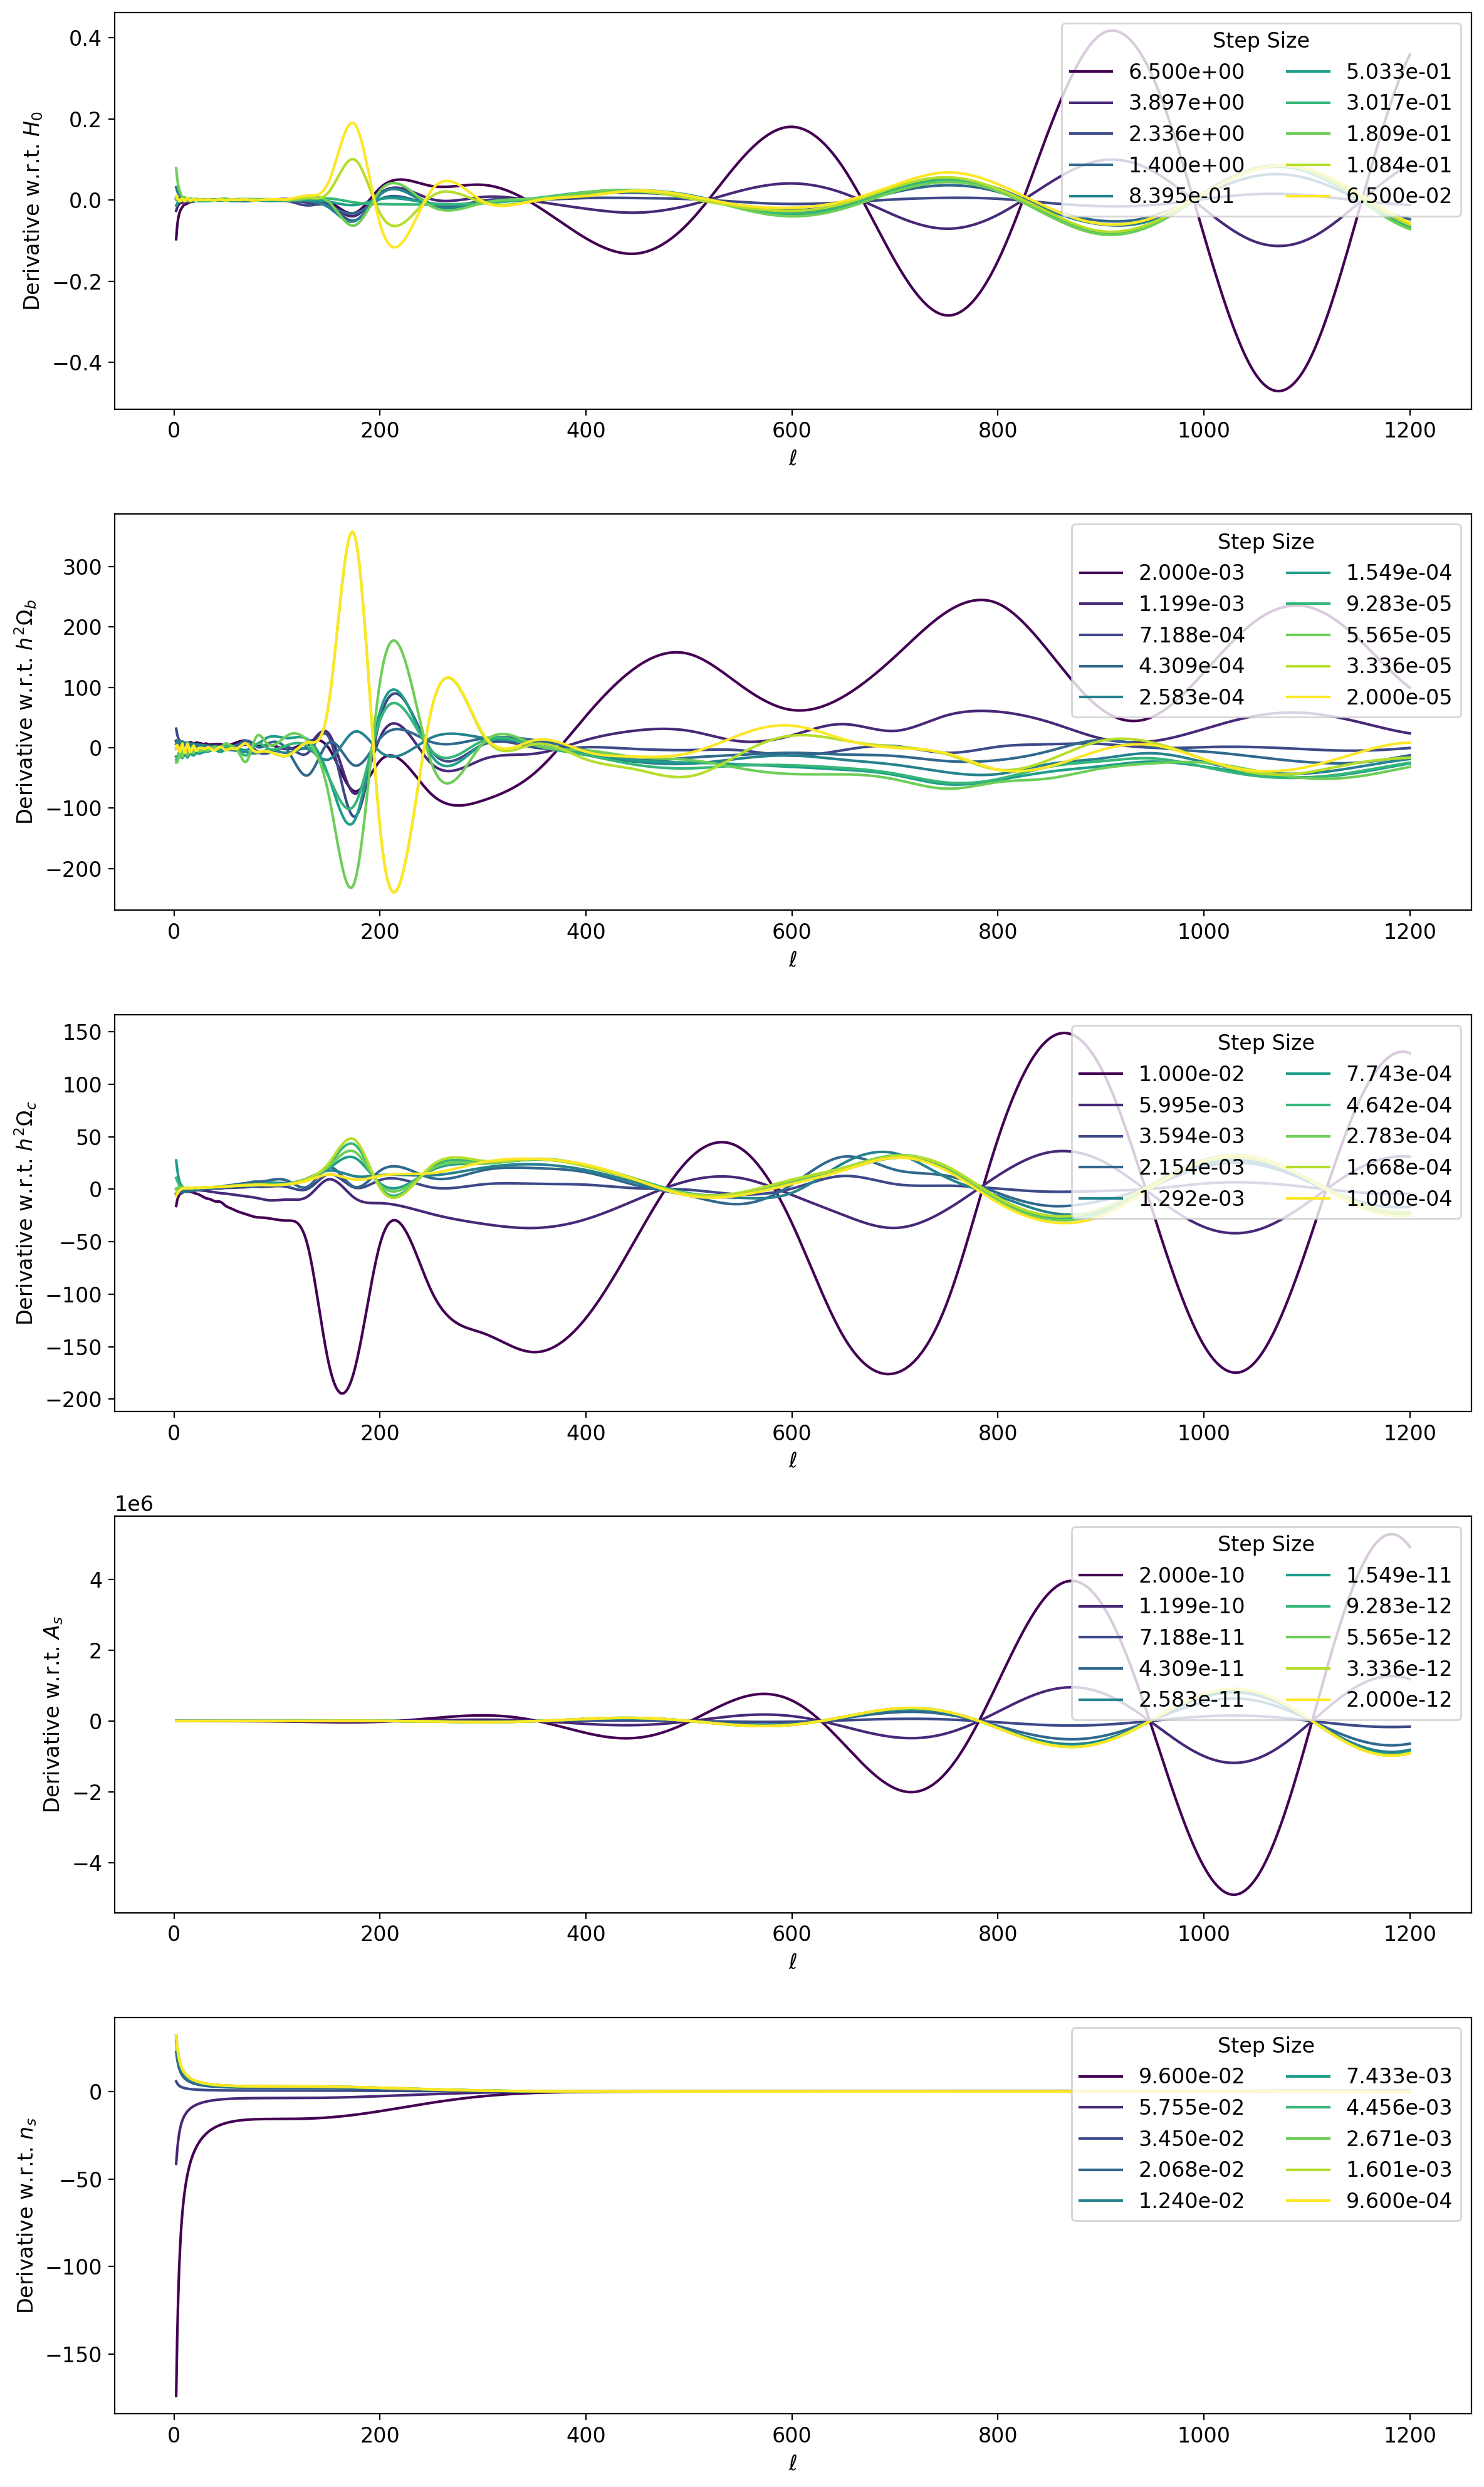

In [44]:
fig, axes = plt.subplots(params.size, figsize=(12,20))
param_names = [r"$H_0$", r"$h^2\Omega_b$", r"$h^2\Omega_c$", r"$A_s$", r"$n_s$"]
cmap = plt.cm.viridis
norm = plt.cm.colors.Normalize(vmin=0, vmax=fractional_step_sizes.size - 1)
for i, (ax, name) in enumerate(zip(axes, param_names)):
    ax.set_xlabel(r"$\ell$")
    ax.set_ylabel(f"Derivative w.r.t. {name}")
    for j, step_size in enumerate(fractional_step_sizes):
        step_size *= param_history[i,0]
        color = cmap(norm(j))
        label = f"{step_size:.3e}"
        ax.plot(ells, deriv_matrix[j, :, i] - deriv_matrix[:, :, i].mean(axis=0), color=color, label=label)
    ax.legend(title="Step Size", ncol=2, loc="upper right")
fig.tight_layout();

The above set of plots show how the partial derivative of the power spectrum changes with varying step size in parameter space. By eye, it looks like the derivative converges very quickly for every $\ell$ for each parameter varied.

## Problem 4

In [109]:
# MCMC code based on the code from lecture
def run_mcmc(
    data, start_params, step_size, chisq_func, model_func, Nsteps=5000, corr_mat=None
):
    """
    Run a Monte-Carlo Markov Chain to find the best-fit parameters for a model.
    
    Parameters
    ----------
    data: ndarray
        Array with the data and errors, should have shape (N,3) where
        data[:,0] gives l-modes; data[:,1] gives powers; data[:,2] gives errors.
    start_params: ndarray
        Initial guess for the best-fit parameters.
    step_size: ndarray
        Step size to use for calculating the derivative of the model function.
    chisq_func: callable
        Function for calculating chi-squared. Should have signature
        ``chisq_func(data, params, model_func)``.
    model_func: callable
        Model function to use when evaluating chi-squared. Should have signature
        ``model_func(ell, params)``.
    Nsteps: int, optional
        Number of steps to take in the chain. Default is 5000.
    corr_mat: ndarray, optional
        Matrix used to induce correlations on the steps in the chain. Default
        is to assume there are no correlations in the data.
        
    Returns
    -------
    chain: ndarray
        Path taken by the chain in phase space. Has shape
        ``(Nsteps, start_params.size)``.
    chisq_history: ndarray
        Chi-squared at each point sampled by the chain.
    """
    # Setup important objects.
    chain = np.zeros([Nsteps, start_params.size])
    chisq_history = np.zeros(Nsteps)
    current_chisq = chisq_func(data, start_params, model_func)
    current_params = start_params.copy()  # So we don't alter parameters in-place
    if corr_mat is None:
        corr_mat = np.eye(start_params.size)
    
    # Start the chain.
    for step in range(Nsteps):
        dpars = stats.norm.rvs(loc=0, scale=step_size, size=current_params.size)
        dpars = corr_mat @ dpars
        
        # Hard-code that third parameter is optical depth. Reject steps that push
        # optical depth negative, but don't count them as steps rejected by the chain.
        while current_params[3] + dpars[3] < 0:
            dpars = stats.norm.rvs(loc=0, scale=step_size, size=current_params.size)
            dpars = corr_mat @ dpars
        
        # Figure out whether we take a step or not.
        trial_params = current_params + dpars
        trial_chisq = chisq_func(data, trial_params, model_func)
        accept_probability = np.exp(-0.5 * (trial_chisq - current_chisq))
        if stats.uniform.rvs() < accept_probability:
            current_params = trial_params
            current_chisq = trial_chisq
            
        # Update the chain.
        chain[step] = current_params
        chisq_history[step] = current_chisq
        
    # We're done, so return the results.
    return chain, chisq_history

In [90]:
# For use in the MCMC.
def calc_chisq(data, params, model_func):
    """
    Calculate chi-squared for the given data, model, and parameters.
    
    Parameters
    ----------
    data: ndarray
        Array with the data and errors, should have shape (N,3) where
        data[:,0] gives l-modes; data[:,1] gives powers; data[:,2] gives errors.
    params: ndarray
        Parameters to use for evaluating the model.
    model_func: callable
        Model function to use when evaluating chi-squared. Should have signature
        ``model_func(ell, params)``.

    Returns
    -------
    chisq: float
        Chi-squared for the given model.
    """
    ells, powers, errors = data.T
    model = model_func(ells, params)
    resid = powers - model
    ninv = np.diag(1 / errors ** 2)
    return resid.T @ ninv @ resid

In [117]:
def calc_spectrum_packed_args(ell, params):
    return calc_spectrum(ell, *params)

In [106]:
# Set up the parameters and get the correlation matrix.
mcmc_start_params = np.insert(best_fit_params, 3, tau)
mcmc_dpars = 0.001 * mcmc_start_params
Nsteps = 10
derivs = calc_derivs(
    ells, mcmc_start_params, mcmc_dpars, calc_spectrum_packed_args
)
ninv = np.diag(1 / errors ** 2)
curvature = np.linalg.inv(derivs.T @ ninv @ derivs)
corr_mat = np.linalg.cholesky(curvature)

In [122]:
chain, chisq_history = run_mcmc(
    data[:, :3],
    mcmc_start_params,
    mcmc_dpars,
    calc_chisq,
    lambda ell, params: calc_spectrum(ell, *params),
    Nsteps=Nsteps,
    corr_mat=corr_mat,
)

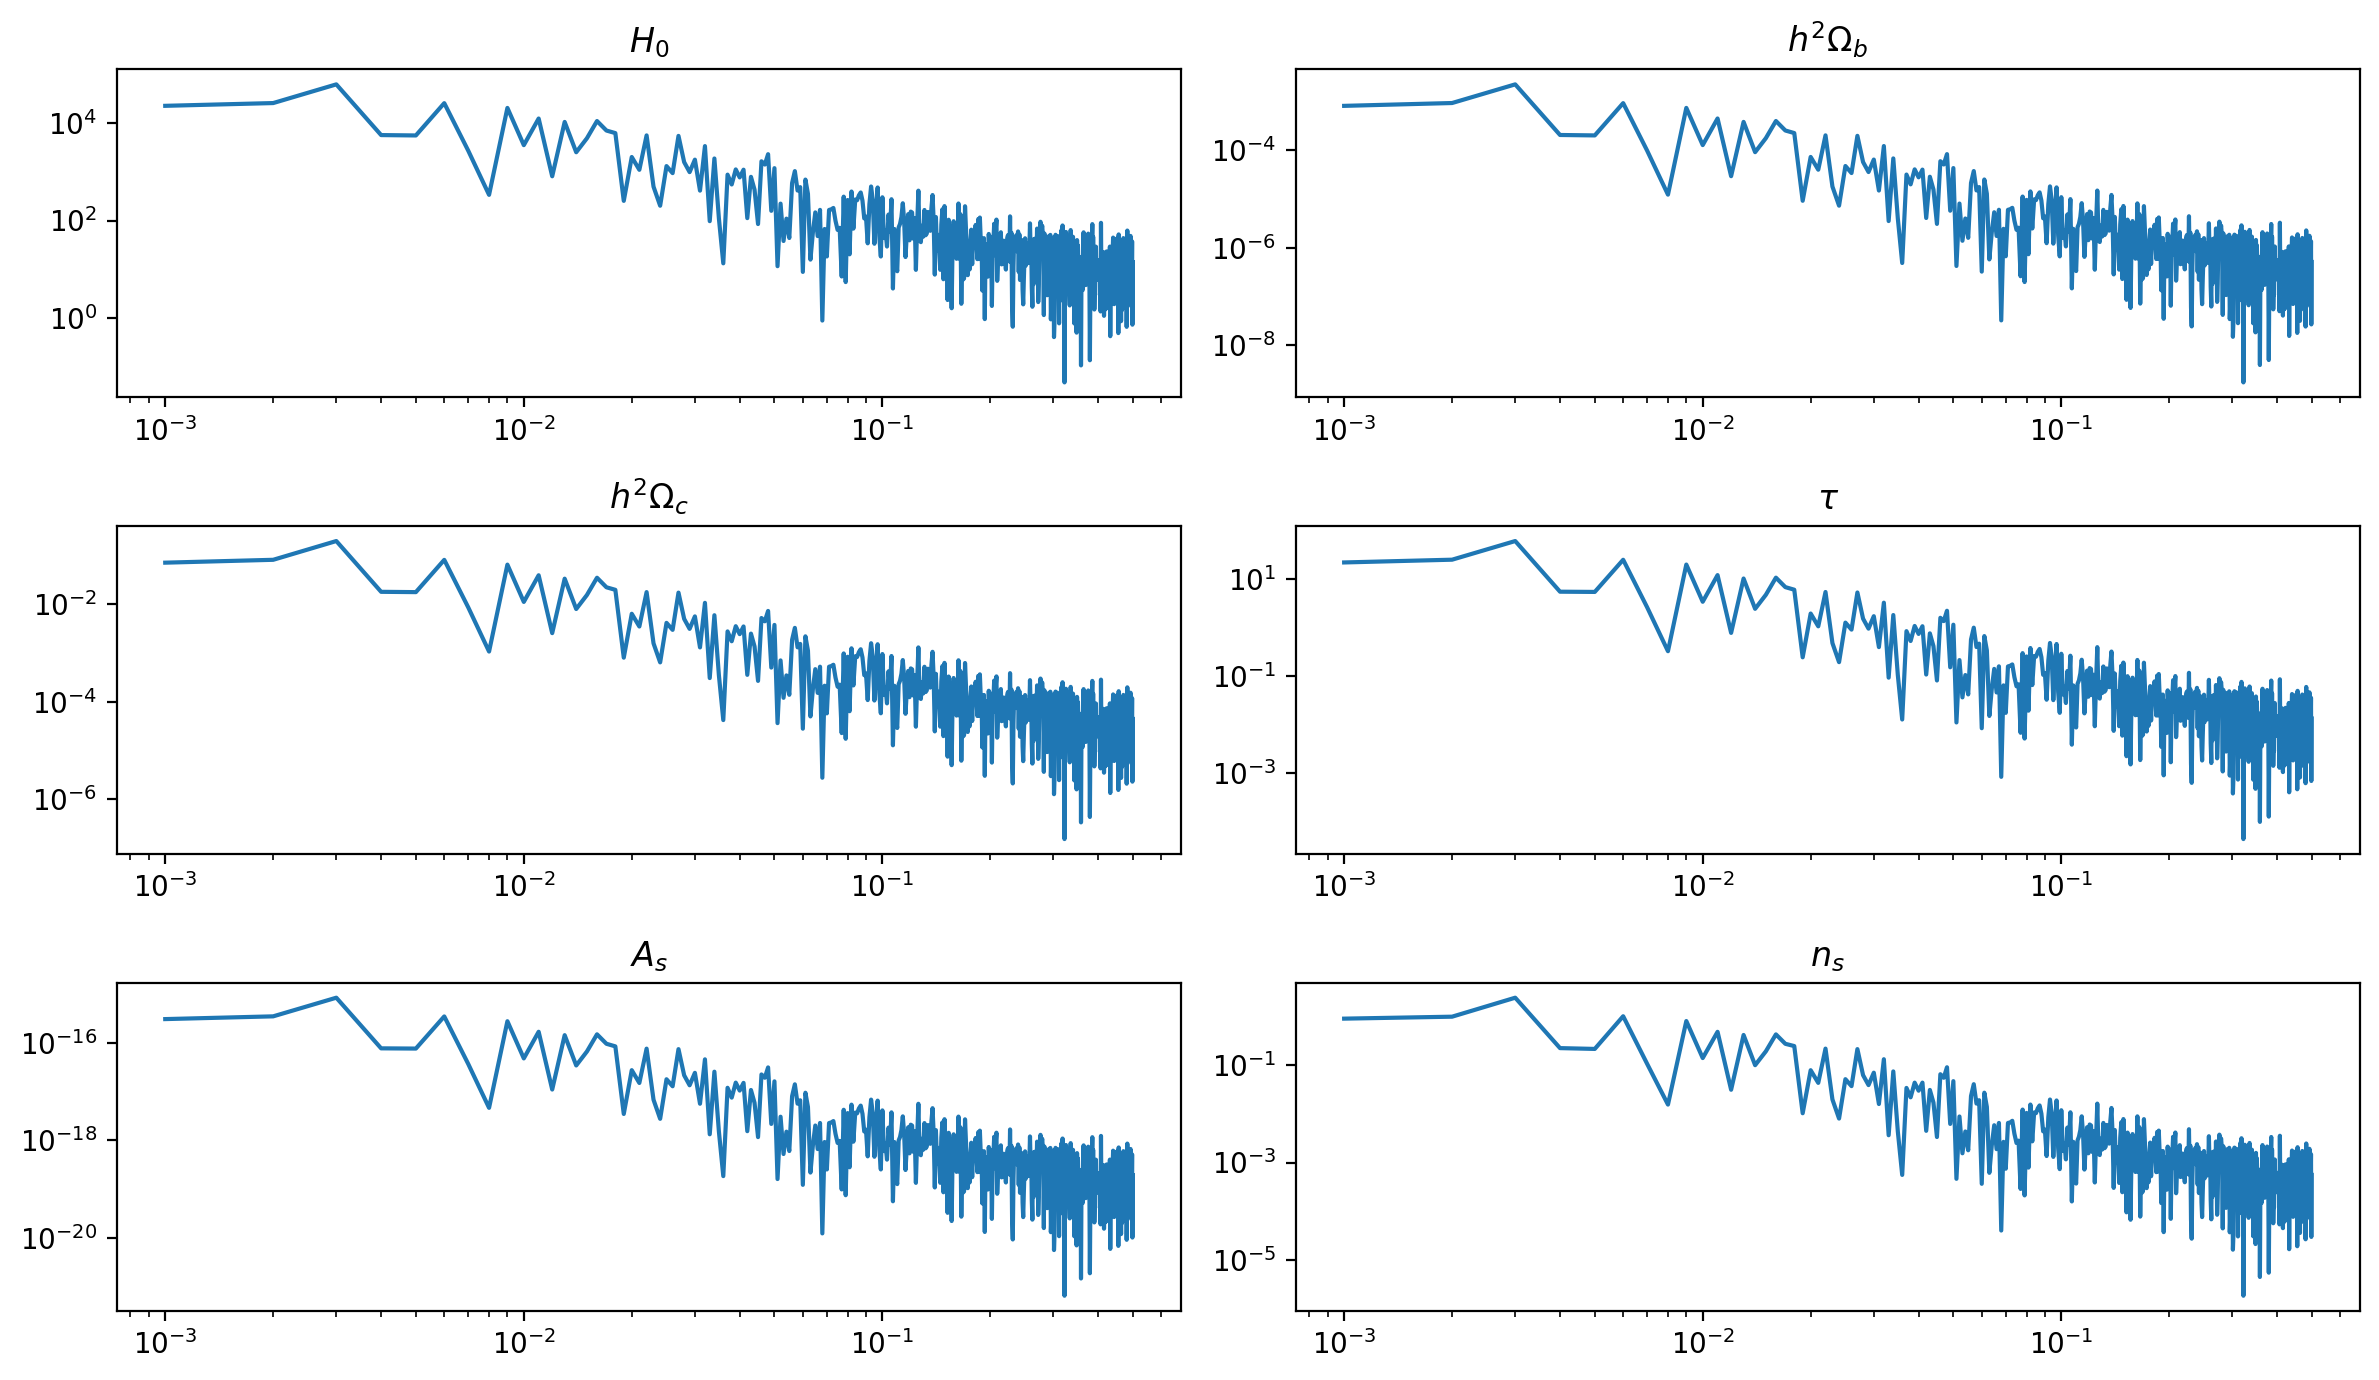

In [191]:
freqs = np.fft.fftfreq(Nsteps)
fig, axes = plt.subplots(3, 2, figsize=(12,7), dpi=200)
for j, (ax, param) in enumerate(zip(axes.ravel(), labels)):
    chain_pspec = np.abs(np.fft.fft(chain[:,j])) ** 2
    chain_pspec = 0.5 * (chain_pspec[1:500] + chain_pspec[500:-1]) 
    ax.loglog(freqs[1:500], np.abs(np.fft.fft(chain[:,j])[1:500])**2)
    ax.set_title(param)
fig.tight_layout()

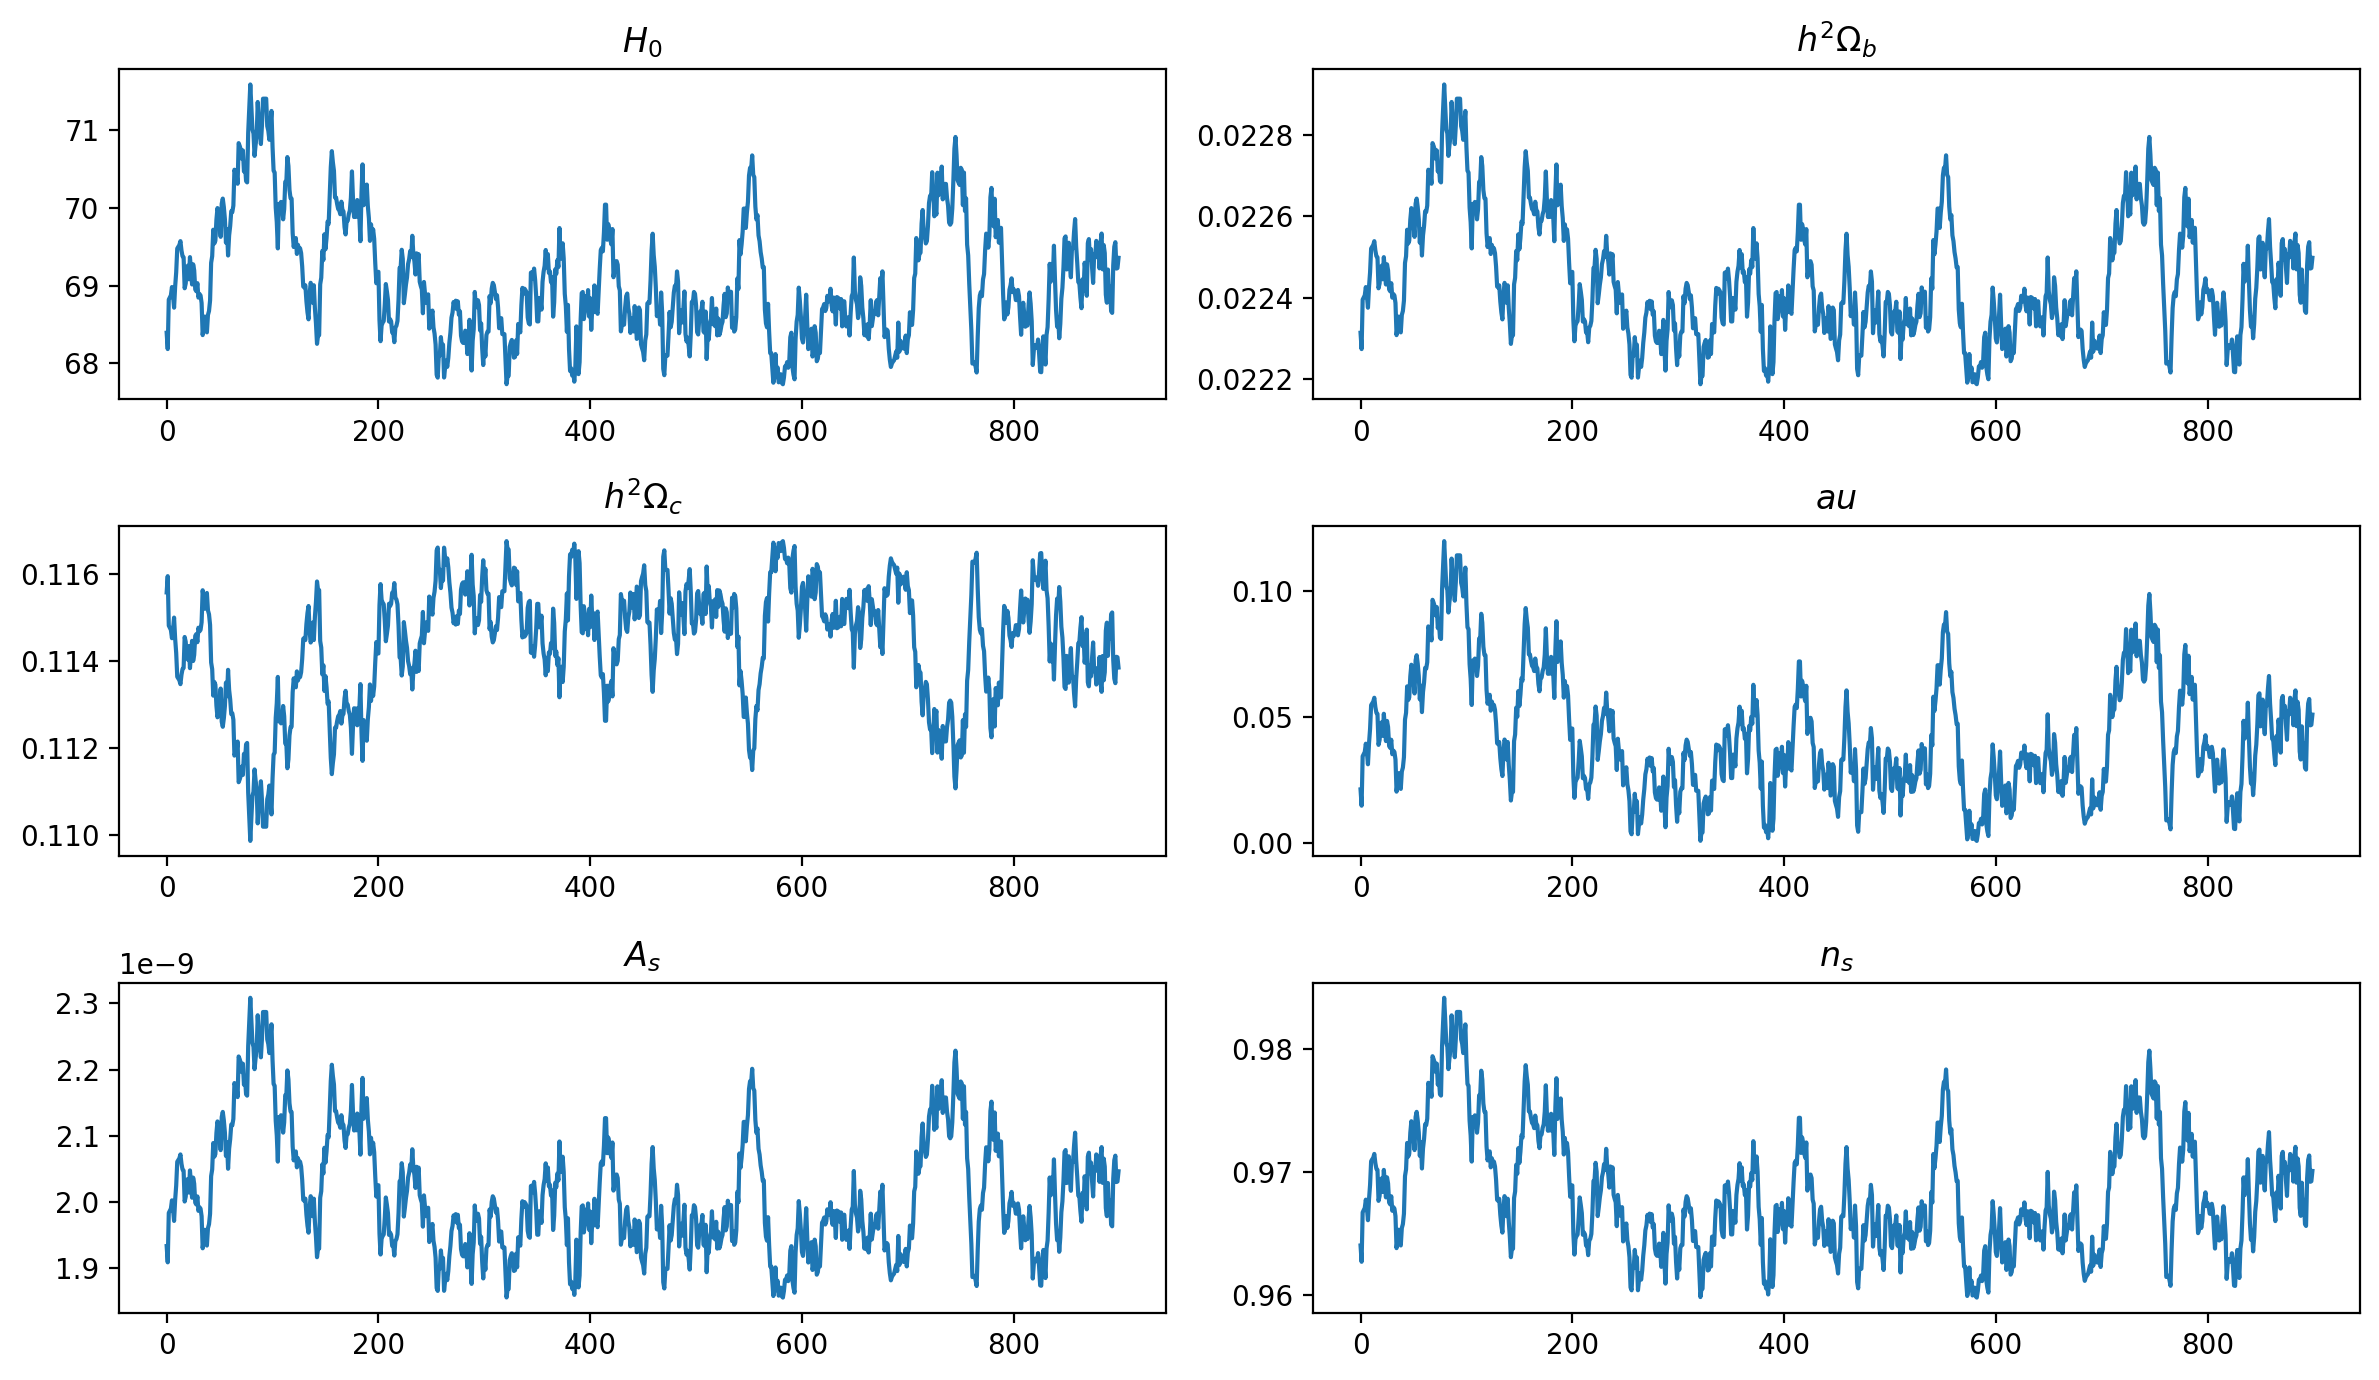

In [164]:
fig, axes = plt.subplots(3, 2, figsize=(12,7), dpi=200)
for j, (ax, param) in enumerate(zip(axes.ravel(), labels)):
    ax.plot(chain[Nsteps // 10:,j])
    ax.set_title(param)
fig.tight_layout()

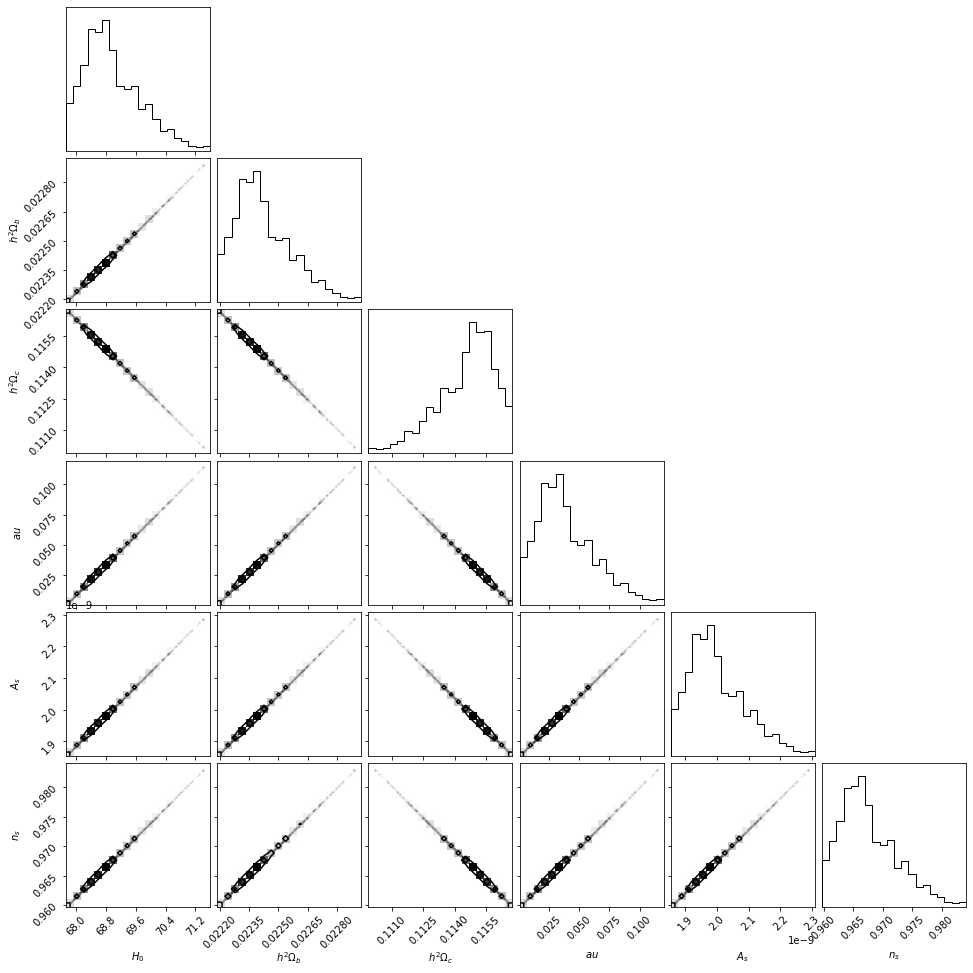

In [165]:
fig = corner.corner(chain, labels=labels)